In [1]:
## Messing around with data from the hits database (and comparing to the stamps database)
# Stamps are voltage data over time (waterfall plots) saved when seticore detects a strong signal hit
# Hits are saved for all signals seticore detects, stamps are only saved for the strongest ones
# The hits in the stamp database are only those strongest signals stamps were saved for
# The hits in the 'all hits' database include those not strong enough to save a stamp for
# There are more hits than 'stamps' because the stamps database only saves the strongest signals
# in each stamp file, whereas the hits database has all hits detected by seticore
# Hypothesis: There will be multiple seticore hits per signal, so the hits will cluster
#             Only the strongest hit in the file gets saved as a stamps hit

## Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time

In [5]:
# Read in data from hits and stamps database
# Hits data is just that which is on source 3127348761205770496
# The stamp hits file contains hits on all targets
data_dir = "/datax/scratch/nstieg/"
target_source = "3127348761205770496"

# Read in data from all hits database
# These are all from coherent beamformed hits on the target
all_hits_filename = "3127348761205770496-hits.pkl"
all_hits = pd.read_pickle(data_dir + all_hits_filename)
print("All hits on 3127348761205770496: ", all_hits.shape)
sources_in_all_hits = all_hits["source_name"].unique()
assert(len(sources_in_all_hits) == 1)
assert(sources_in_all_hits[0] == target_source)
# Convert times to human readable times
assert("tstart_h" in stamp_hits.columns)
all_hits["tstart_h"] = Time(all_hits["tstart"], format="mjd").datetime
assert("tstart_h" in all_hits.columns)

# Read in stamp hits. Reading from the coherent data because this is the data
# where a beam was formed on a coherent target. This data has fewer columns
# because it's been trimmed down to just contain relevant information for
# finding technosignatures
stamp_hits_filename = "25GHz_higher_coherent.pkl"
stamp_hits = pd.read_pickle(data_dir + stamp_hits_filename)
print("All coherent stamps", stamp_hits.shape)
stamp_hits = stamp_hits[stamp_hits["source_name"] == target_source] # Keep data on target to compare
sources_in_stamp_hits = stamp_hits["source_name"].unique()
assert(len(sources_in_stamp_hits) == 1)
assert(sources_in_stamp_hits[0] == target_source)
print("Coherent stamps on target", stamp_hits.shape)

# See how many more signals there are of one than another
num_all_hits = len(all_hits)
num_stamp_hits = len(stamp_hits)
print(f"{num_all_hits - num_stamp_hits} more signals saved in the all-hits database than the stamp database")

# Check if the signals saved in both have the same IDs
common_hits = pd.merge(all_hits, stamp_hits, on='id', how='inner')
print(f"{len(common_hits)} hits in common")

# See which are in just one or the other
ids_in_all_hits_only = set(all_hits['id']).difference(set(stamp_hits['id']))
ids_in_stamp_hits_only = set(stamp_hits['id']).difference(set(all_hits['id']))
in_all_hits_only = all_hits[all_hits["id"].isin(ids_in_all_hits_only)]
print(f"{len(ids_in_all_hits_only)} hits are only in the all hits database")
print(f"{len(ids_in_stamp_hits_only)} hits are only in the stamp hits database")

All hits on 3127348761205770496:  (71812, 29)
All coherent stamps (2984740, 13)
Coherent stamps on target (71425, 13)
387 more signals saved in the all-hits database than the stamp database
71425 hits in common
387 hits are only in the all hits database
0 hits are only in the stamp hits database


## Plot data

<Axes: xlabel='signal_frequency', ylabel='signal_drift_rate'>

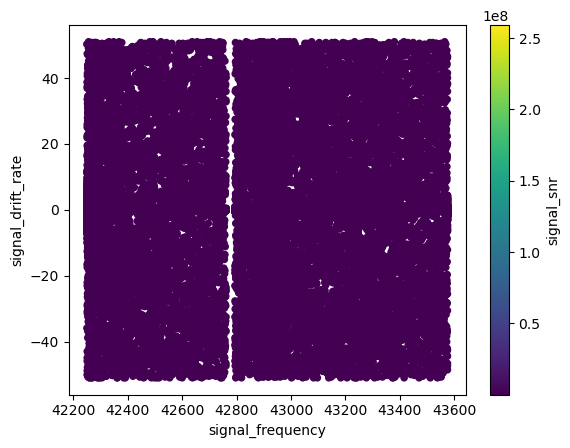

In [109]:
all_hits.plot.scatter("signal_frequency", "signal_drift_rate", c="signal_snr")

<Axes: xlabel='signal_frequency', ylabel='signal_drift_rate'>

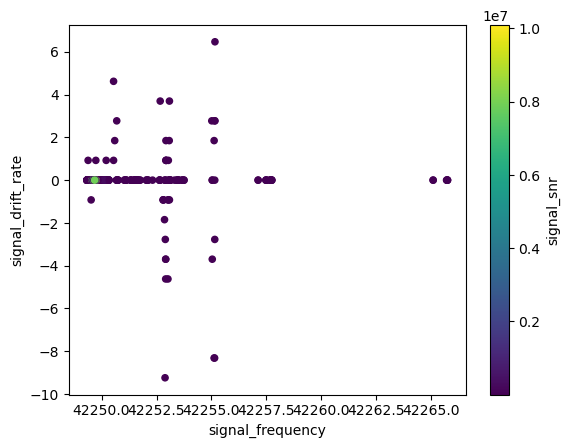

In [33]:
# Look at the hits which aren't in common
in_all_hits_only.plot.scatter("signal_frequency", "signal_drift_rate", c="signal_snr")

In [15]:
# Plot the stamps hits versus the 
# unique hits on the same axes to see
# where seticore decided not to make a hit
# Pass in the names of the df columns
# to make the x and y axes
def look_at_unique_signals(x, y):
    stamp_hits_x = stamp_hits[x]
    stamp_hits_y = stamp_hits[y]
    in_all_hits_x = in_all_hits_only[x]
    in_all_hits_y = in_all_hits_only[y]
    plt.scatter(stamp_hits_x, stamp_hits_y, marker=".")
    plt.scatter(in_all_hits_x, in_all_hits_y, marker='.', color="red", zorder=1000)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

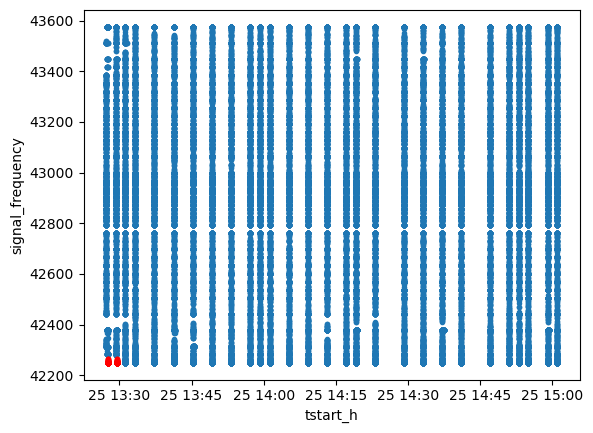

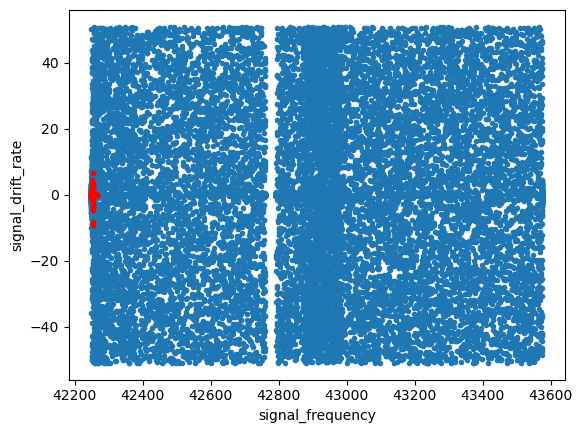

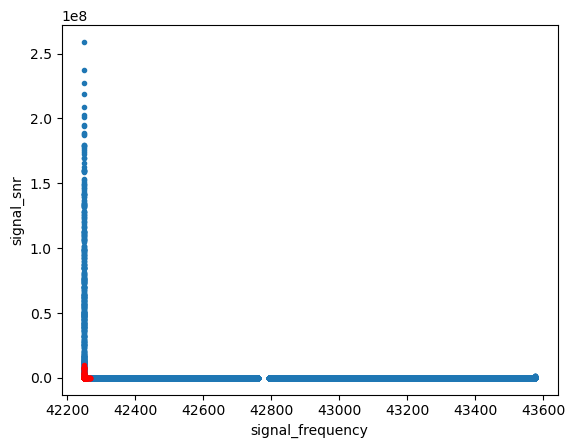

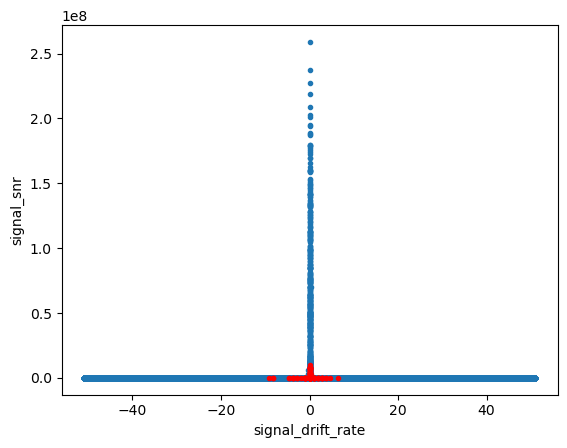

In [18]:
look_at_unique_signals("tstart_h", "signal_frequency")
look_at_unique_signals("signal_frequency", "signal_drift_rate")
look_at_unique_signals("signal_frequency", "signal_snr")
look_at_unique_signals("signal_drift_rate", "signal_snr")



## Look at statistics of data

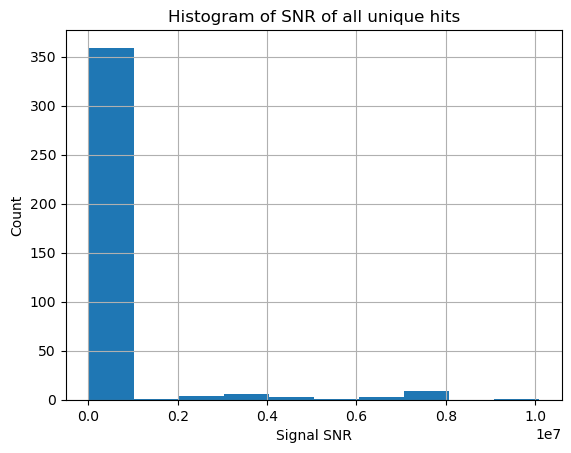

37.26460266113281


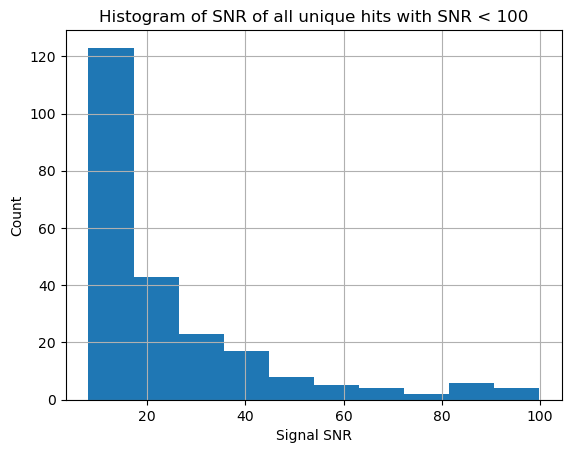

In [43]:
# Look at SNR of these hits
in_all_hits_only.hist("signal_snr")
plt.xlabel("Signal SNR")
plt.ylabel("Count")
plt.title("Histogram of SNR of all unique hits")
plt.show()

# Look at median SNR
print(in_all_hits_only["signal_snr"].median())

# Look at all SNR < 100
in_all_hits_only[in_all_hits_only["signal_snr"] < 100].hist("signal_snr")
plt.xlabel("Signal SNR")
plt.ylabel("Count")
plt.title("Histogram of SNR of all unique hits with SNR < 100")
plt.show()

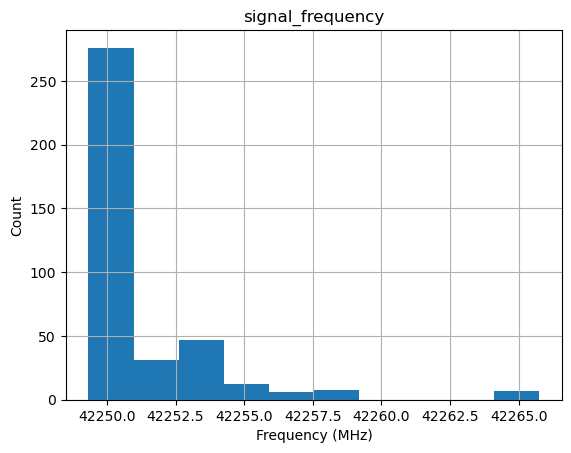

In [46]:
# Look at frequencies of these signals
in_all_hits_only.hist("signal_frequency")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Count")
plt.show()

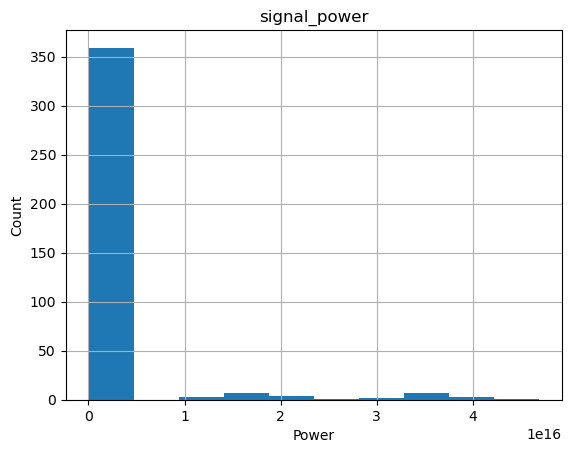

In [52]:
# Look at frequencies of these signals
in_all_hits_only.hist("signal_power")
plt.xlabel("Power")
plt.ylabel("Count")
plt.show()

In [51]:
# What beams did these come from?
print(in_all_hits_only["signal_beam"].unique()) # Only 1 beam in unique
print(stamp_hits["signal_beam"].unique()) # Only 1 beam in the other hits too

[0]
[0]


## Compute distances

In [75]:
# Check if any of the unique hits are close to a hit in the stamp database

# Make an array to hold the frequencydistance between any two hits
distances = np.zeros((len(in_all_hits_only), len(stamp_hits))) - 1 # -1 is a sentinel
print(distances.shape)
print(distances[0:4])

# Collect frequencies to compare
all_hits_only_frequencies = in_all_hits_only["signal_frequency"]
stamp_hits_frequencies = stamp_hits["signal_frequency"]

# Compute indices
for hit_index in range(len(in_all_hits_only)):
    for stamp_hit_index in range(len(stamp_hits)):
        distances[hit_index, stamp_hit_index] = all_hits_only_frequencies.iloc[hit_index] - stamp_hits_frequencies.iloc[stamp_hit_index]


(387, 71425)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


## Analyze distances

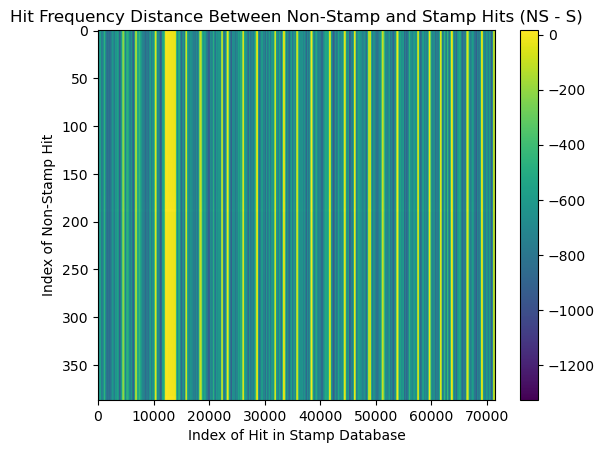

In [101]:
# Visualize distance matrix
plt.imshow(distances, aspect="auto")
plt.colorbar()
plt.xlabel("Index of Hit in Stamp Database")
plt.ylabel("Index of Non-Stamp Hit")
plt.title("Hit Frequency Distance Between Non-Stamp and Stamp Hits (NS - S)")
plt.show()

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
There are 954 hits within 2.0 Hz of another hit


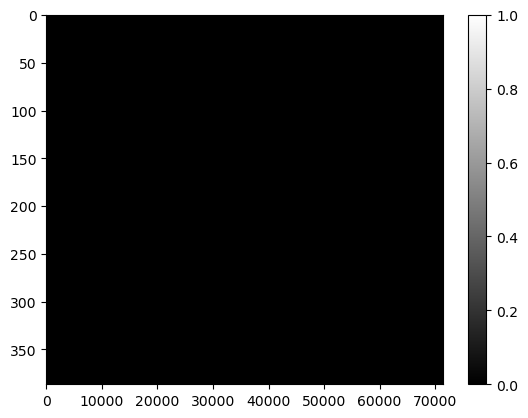

In [102]:
# See if any of the unique hits are next to any of the stamp hits
adjacency_threshold = 2e-6 # How far they can be in MHz (say 2 Hz is adjacent)
adjacency = abs(distances) < adjacency_threshold
print(adjacency)
print("There are", adjacency.sum(), "hits within", adjacency_threshold * 1e6, "Hz of another hit" )

# Visualize Adjacency
plt.imshow(adjacency, cmap="gray", aspect="auto")
plt.colorbar()
plt.show()

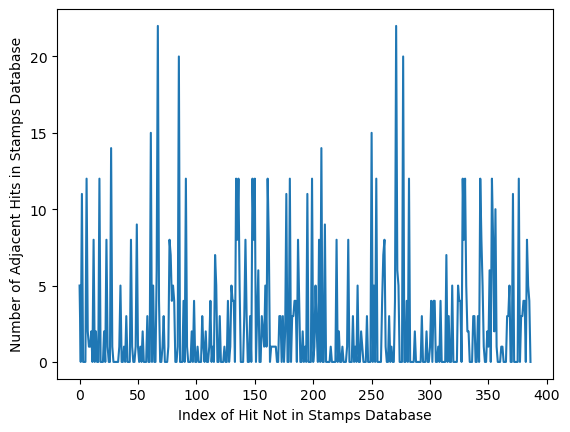

In [87]:
# See which rows have adjacent points ()
adjacent_per_unique_hit = np.zeros(len(in_all_hits_only))
for i, row in enumerate(adjacency):
    adjacent_per_unique_hit[i] = row.sum()

plt.plot(adjacent_per_unique_hit)
plt.xlabel("Index of Hit Not in Stamps Database")
plt.ylabel("Number of Adjacent Hits in Stamps Database")
plt.show()